# To generate plots for Figure 3 of the paper

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from matplotlib import rc
from copy import deepcopy
import scipy.stats as ss
rc('text', usetex=False)
import matplotlib
from cycler import cycler
import palettable
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
def std_percentile(arr):
    return np.percentile(arr,75) - np.percentile(arr,25)

The theory is the following: the fitness of each insertion is $y_{i} = \rho_i y  + \sqrt{1 - \rho_i^2}\eta$ with $\langle \eta \rangle < 0$ and variance equal to that of $y_{\alpha}$. Over all mutations, you have then a distribution of $\rho$ values, $P(\rho)$. The mean DFE is given by $(\langle \rho \rangle -1)y$

In [2]:
df = pd.read_excel("science_data_clean.xlsx")
df.as_matrix()

data_arr = np.array(df)

nz_cols = (data_arr[-1,:] == data_arr[-1,:])*(np.nanmean(data_arr[:-1],axis=0) == np.nanmean(data_arr[:-1],axis=0))

dfe = data_arr[:-1,nz_cols]
brg = data_arr[-1,nz_cols]

dfe_mean = np.nanmean(dfe,axis=0)
dfe_std = np.nanstd(dfe,axis=0)
#dfe_skew = ss.skew(dfe,axis=0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


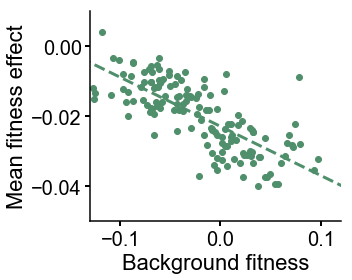

In [3]:
plt.close("all")
plt.rc('axes', prop_cycle=(cycler('color', palettable.wesanderson.Moonrise4_5.mpl_colors)))



fig,axis = plt.subplots(1,1,figsize = (5,4))
fits = np.polyfit(brg,dfe_mean,1)
axis.plot(brg,dfe_mean,'C2o')
#axis.plot(brg,brg,'o')
x = np.linspace(-0.14,0.14,10)
axis.plot(x,x*fits[0] + fits[1],'C2--',lw = 3, alpha = 1)
#axis.plot(x,x*0,'k--',lw = 2)

axis.set_xlim(-.13,0.12)
axis.set_ylim(-0.05,0.01)
axis.set_xlabel(r"Background fitness",fontsize = 22)
axis.set_ylabel("Mean fitness effect",fontsize = 22)
axis.tick_params(labelsize = 20, width = 2, size = 5)
#leg = axis.legend(fontsize = 18, frameon = False)

axis.set_yticks([-0.04,-0.02,0])
axis.set_xticks([-0.1,0,0.1])

axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.5)
axis.spines['bottom'].set_linewidth(1.5)
axis.spines['right'].set_linewidth(0)
fig.tight_layout()
fig.savefig("./RandomQTL_Plots/johnsonetal_dfemean.pdf")
plt.show()

In [4]:
corrs_rhos = []
indices = []
ins_muts_all = []
brg_muts_all = []
intercepts_muts_all = []
for i in range(dfe.shape[0]):
    dfe_muts = (dfe[i])[dfe[i] == dfe[i]]
    brg_muts = brg[dfe[i] == dfe[i]]
    
    sorted_ = np.argsort(brg_muts)
    if len(dfe_muts) < 30: #remove mutations which only have a few non-NaN values
        continue
    
    brg_i = deepcopy(brg_muts)
    ins_i = brg_muts + dfe_muts
    mean1 = np.mean(brg_i)
    mean2 = np.mean(ins_i)
    std1 = np.std(brg_i)
    std2 = np.std(ins_i)
    corr= np.mean((brg_i - mean1)*(ins_i - mean2))/(std1*std2)
    corrs_rhos += [corr]
    
    intercepts_muts_all += [np.polyfit(brg_muts, dfe_muts + brg_muts,1)[1]]
    
    indices += [i]
    ins_muts = deepcopy(brg_muts + dfe_muts)
    ins_muts_all += [ins_muts]
    brg_muts_all += [brg_muts]


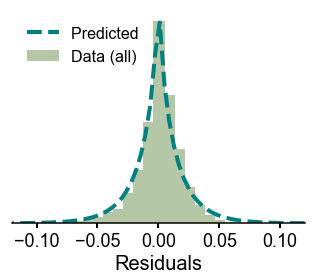

In [5]:
#DFE of various quartiles
plt.rc('axes', prop_cycle=(cycler('color', palettable.cartocolors.diverging.Geyser_5.mpl_colors)))

residuals = []
corrs_rhos = np.array(corrs_rhos)
for i in range(len(corrs_rhos)):
    pred = corrs_rhos[i]*brg_muts_all[i] 
    ins_y =  ins_muts_all[i] 
    ins_y = ins_y - pred - np.mean(ins_y - pred)
    
    residuals += list(ins_y)
residuals = np.array(residuals)
    
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4.5,4))

rho2 = np.abs(1 - corrs_rhos**2)

totalvar=np.std(brg)**2 #Estimate genetic variance

bins = np.linspace(-0.12,0.12,30)
axis.hist(residuals, bins = bins, width= bins[1] - bins[0] + 0.001,color = 'C1', density = True, label = "Data (all)")

dist = np.sqrt(totalvar)*(np.sqrt(rho2[:,None])*(np.random.randn(1,20000))).flatten() #Draw Gaussian RVs
dist += 0*np.sqrt(totalvar)*np.random.randn(dist.shape[0]) #need to add Gaussian noise if there is measurement error

n,bins = np.histogram(dist,bins = 100,density = True)
bins = 0.5*(bins[1:] + bins[:-1])
axis.plot(bins, n, 'C0--', lw = 4, label = "Predicted ")


#axis.set_yscale('log')

axis.set_xlim(-.12,0.12)
#axis.set_ylim(0,58)
axis.set_xlabel(r"Residuals",fontsize = 20)
#axis.set_ylabel("PDF",fontsize = 22)
axis.tick_params(labelsize = 18, width = 2, size = 5)
leg = axis.legend(fontsize = 16, loc = 2,frameon = False)
#axis.set_yticks([-0.05,0])
#axis.set_xticks([-0.1,0,0.1])
axis.set_yticks([])
axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(0)
axis.spines['bottom'].set_linewidth(1.5)
axis.spines['right'].set_linewidth(0)
fig.tight_layout()
fig.savefig("./RandomQTL_Plots/residuals_pdf.pdf")
plt.show()

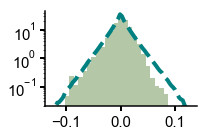

In [7]:
#Inset for previous figure
plt.rc('axes', prop_cycle=(cycler('color', palettable.cartocolors.diverging.Geyser_5.mpl_colors)))

residuals = []
corrs_rhos = np.array(corrs_rhos)
for i in range(len(corrs_rhos)):
    pred = corrs_rhos[i]*brg_muts_all[i]
    ins_y =  ins_muts_all[i]
    ins_y = ins_y - pred - np.mean(ins_y - pred)
    
    residuals += list(ins_y)
residuals = np.array(residuals)
    
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (3,2))

rho2 = np.abs(1 - corrs_rhos**2)

totalvar=np.std(brg)**2 #Estimate genetic variance

dist = np.sqrt(totalvar)*(np.sqrt(rho2[:,None])*(np.random.randn(1,20000))).flatten() #Draw Gaussian RVs
dist += 0*np.sqrt(totalvar)*np.random.randn(dist.shape[0]) #need to add Gaussian noise if there is measurement error

n,bins = np.histogram(dist,bins = 100,density = True)
bins = 0.5*(bins[1:] + bins[:-1])
axis.plot(bins,n, 'C0--', lw = 4, label = "Predicted")

bins = np.linspace(-0.12,0.12,30)
axis.hist(residuals, bins = bins, width= bins[1] - bins[0] + 0.001,color = 'C1', density = True, label = "Data (all)")
axis.set_yscale('log')

axis.set_xlim(-.14,0.14)
axis.set_ylim(0.02,45)
#axis.set_xlabel(r"Residuals",fontsize = 22)
axis.tick_params(labelsize = 15, width = 2, size = 5)

#axis.set_yticks([])
axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.5)
axis.spines['bottom'].set_linewidth(1.5)
axis.spines['right'].set_linewidth(0)
fig.tight_layout()
fig.savefig("./RandomQTL_Plots/residuals_pdf_inset.pdf")
plt.show()


0.002627641091726133


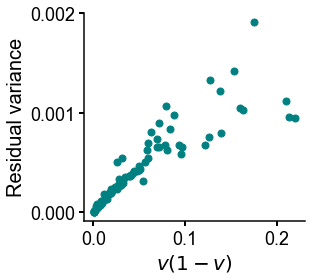

0.8017777344427118


In [8]:
#Slope and Residual variance
varss = []

vs = (1 - np.array(corrs_rhos))/2
for i in range(len(corrs_rhos)):
    pred = corrs_rhos[i]*brg_muts_all[i]
    ins_y =  deepcopy(ins_muts_all[i])
    ins_y = ins_y - pred
    varss += [np.std(ins_y)**2]
    
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4.5,4))
totalvar=np.std(brg)**2
print(totalvar)
axis.plot(vs*(1-vs),np.array(varss),'C0o', ms = 7)


#axis.plot(xs,xs,'k--',lw = 2)
# axis.set_xlim(0*totalvar,0.9*totalvar)
# axis.set_ylim(0*totalvar,0.9*totalvar)

bf = np.polyfit(vs*(1-vs),np.array(varss),1)
xs =np.linspace(0,0.25)
#axis.plot(xs,xs*bf[0] + bf[1], 'C0--', lw = 2)

axis.set_yticks([0,0.001,0.002])
axis.set_xlabel(r"${v}(1-{v})$",fontsize = 20)
axis.set_ylabel("Residual variance",fontsize = 20)
axis.tick_params(labelsize = 18, width = 2, size = 5)

axis.set_xticks([0,0.1,0.2])

axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.5)
axis.spines['bottom'].set_linewidth(1.5)
axis.spines['right'].set_linewidth(0)
fig.tight_layout()
fig.savefig("./RandomQTL_Plots/johnson_resvar_slope.pdf")
plt.show()

corrmatrix = np.corrcoef(vs*(1-vs),np.array(varss))
print(corrmatrix[0,1]**2)

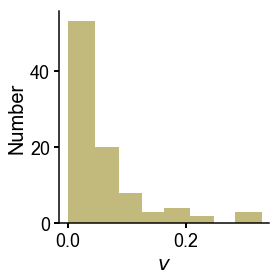

In [9]:
#Distribution of variance fractions
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4,4))
plt.rc('axes', prop_cycle=(cycler('color', palettable.wesanderson.Moonrise2_4.mpl_colors)))
vs = (1 - np.array(corrs_rhos))/2
axis.hist(vs,bins = 8, color='C2', width = 0.045)

axis.tick_params(labelsize =18, width = 2, size = 5)

axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.5)
axis.spines['bottom'].set_linewidth(1.5)
axis.spines['right'].set_linewidth(0)


axis.set_ylabel(r"Number",fontsize = 20)
axis.set_xlabel(r"${v}$",fontsize = 20)
fig.tight_layout()
fig.savefig("./RandomQTL_Plots/v_dist_johnson.pdf")
plt.show()

In [10]:
print(np.argsort(-vs))

[36 18 76 24 11 59 60 50  2 33 40 17 44 54 66 82 89 12 67 19 71 88 51 61
 34 74  6 68 85 25 10 63 57 43 77 72 47 14 78 53 21 86 29 37 27 48 69 22
 15 87 58 49 28 16 56 39  0 41 91 30 38 26  1 80  8 32 46 70 92  4 65 62
  9 64  7 73  3  5 52 31 55 13 42 20 90 83 79 84 35 23 81 75 45]


123


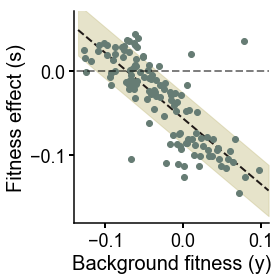

In [11]:
#For cartoon to show slope and residual variance

i = 36

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4,4))

xs = np.linspace(-0.135,0.11)
p = np.polyfit(brg_muts_all[i], ins_muts_all[i]-brg_muts_all[i],1)
axis.plot(xs,p[0]*xs + p[1],'C3--', lw = 2)


s = ins_muts_all[i]-brg_muts_all[i]
y = brg_muts_all[i]
print(len(s))

res_std = np.std(s - (p[0]*y + p[1]))

axis.plot(brg_muts_all[i], ins_muts_all[i]-brg_muts_all[i] , 'C0o')

axis.plot([-0.15,0.15],[0,0],'k--',lw =2 ,alpha=0.5)

axis.tick_params(labelsize =18, width = 2, size = 5)

axis.fill_between(xs, p[0]*xs + p[1] - res_std, p[0]*xs + p[1] + res_std ,color ='C2', alpha = 0.4)

axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.5)
axis.spines['bottom'].set_linewidth(1.5)
axis.spines['right'].set_linewidth(0)

axis.set_ylim(-0.18,0.07)
axis.set_yticks([-0.1,0])
axis.set_xlim(-0.14,0.11)
axis.set_ylabel(r"Fitness effect (s)",fontsize = 20)
axis.set_xlabel(r"Background fitness (y)",fontsize = 20)
fig.tight_layout()
fig.savefig("./RandomQTL_Plots/slope_resvar_example.pdf")
plt.show()

-0.7085952534162497 0.03187845172408134 0.03647612622125
-0.5140064077573487 0.03131718953203835 0.038085255401154997
-1.062669085181554 0.03699843909805722 0.042928440583049995
-1.0886352466424773 0.042505603238868095 0.04954930797918


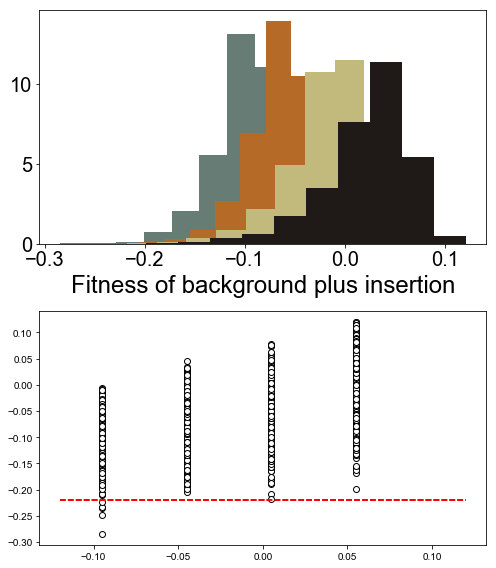

In [13]:
#Extra figure
#DFEs for quartiles

plt.close("all")
fig,axis = plt.subplots(2,1,figsize = (7,8))

fac = 1
fac2 = 0.0

ranges = np.arange(-0.12,0.13,0.05)
means = np.zeros(len(ranges)-1)
stds = np.zeros(len(ranges)-1)
skews = np.zeros(len(ranges)-1)

for i in range(len(ranges)-1):
    filt = (brg > ranges[i])*(brg < ranges[i+1])
    dfe_filt = dfe[:,filt] + fac*brg[filt]
    dfe_filt = dfe_filt.flatten()
    dfe_filt = dfe_filt[dfe_filt == dfe_filt]+ i*fac2
    axis[0].hist(dfe_filt,bins = 10,density=True)
    means[i] = np.mean(dfe_filt)
    stds[i] = np.std(dfe_filt)
    skews[i] = ss.skew(dfe_filt)
    
    bins = (0.5*ranges[i] + 0.5*ranges[i+1])*np.ones(len(dfe_filt))
    axis[1].plot(bins, dfe_filt,'ko', mfc = 'w')
    axis[1].plot([-0.12,0.12],[-0.22,-0.22],'r--')
    print(ss.skew(dfe_filt), np.std(dfe_filt), std_percentile(dfe_filt))
axis[0].set_xlabel("Fitness of background plus insertion", fontsize = 24)
axis[0].tick_params(labelsize = 20)
fig.tight_layout()
plt.show()

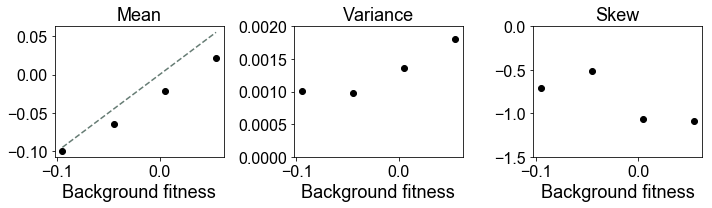

In [18]:
#Reproducing Figure 2 from Johnson et al

plt.close("all")
fig,axis = plt.subplots(1,3,figsize=  (10,3))
bins = 0.5*ranges[1:] + 0.5*ranges[:-1]
axis[0].plot(bins, means, 'ko')
axis[0].plot(bins, bins, '--')
axis[0].tick_params(labelsize = 16)
axis[0].set_xlabel("Background fitness", fontsize = 18)
axis[0].set_title("Mean", fontsize = 18)

axis[1].plot(bins, stds**2, 'ko')
axis[1].tick_params(labelsize = 16)
axis[1].set_ylim(0,0.002)
axis[1].set_xlabel("Background fitness", fontsize = 18)
axis[1].set_title("Variance", fontsize = 18)

axis[2].plot(bins, skews, 'ko')
axis[2].tick_params(labelsize = 16)
#axis.set_xlim(-0.2,0.15)
axis[2].set_ylim(-1.5,0.0)
axis[2].set_xlabel("Background fitness", fontsize = 18)
axis[2].set_title("Skew", fontsize = 18)

fig.tight_layout()
plt.show()